## Parte 1 - Instalando e importando bibliotecas que serão utilizadas

executar os códigos no terminal!

<code>conda create --yes --name workshop1 python=3.7</code>

<code>conda activate workshop1</code>

<code>conda install jupyterlab=2.2.6</code>

<code>conda install -c conda-forge pyproj=2.4.2.post1</code>

<code>conda install -c conda-forge descartes=1.1.0</code>

<code>conda install -c conda-forge geopandas=0.8.1</code>

<code>conda install -c conda-forge geopy=2.0.0</code>

<code>conda install pandas</code>

<code>conda install numpy</code>

<code>conda install matplotlib</code>

In [180]:
# importando bibliotecas que serao utilizadas
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import descartes
import pyproj
import shapely.wkt
import seaborn as sns
from sklearn import metrics
import geopy.distance
from shapely.geometry import Point

## Parte 2 - Importando as informações do DataSet proposta para o projeto

In [181]:
# lendo o conjunto de dados
df = pd.read_csv('Real_State_Properati.csv', sep = '\t')
df_original = df.copy()

## Parte 3 - Entender o que cada coluna significa.

property_type : Tipo de propriedade.

place_name : Nome do bairro.

country_name : Nome do pais.

state_name: Localidade da propriedade.

lat : Latitude

lon : Longitude

price : Preco publicado na propaganda.

currency : tipo de moeda utilizada no anuncio.

surface_total_in_m2 : metragem da area do imovel.

In [182]:
# checando as primeiras linhas do conjunto
df.head()

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0
2,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0
3,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,195000.0,USD,65.0
4,PH,Mataderos,Argentina,Capital Federal,-34.652356,-58.501624,239000.0,USD,140.0


## Após avaliar como os dados estão distribuídos no dataset, nota-se que não existem valores nulos.

In [183]:
# informação das colunas para ver se existem campos nulos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17223 entries, 0 to 17222
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_type        17223 non-null  object 
 1   place_name           17223 non-null  object 
 2   country_name         17223 non-null  object 
 3   state_name           17223 non-null  object 
 4   lat                  17223 non-null  float64
 5   lon                  17223 non-null  float64
 6   price                17223 non-null  float64
 7   currency             17223 non-null  object 
 8   surface_total_in_m2  17223 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.2+ MB


## Convertendo os valores de habitação que estão precificados em Peso Argentino para Dólares dos EUA
Após avaliação inicial nota-se que grande parte das informações estão precificadas em USD

In [184]:
# convertendo preços com moeda ARS para USD

#1 ARS =  0.0085 USD

df['price_ajustado'] = df['price']

df['currency_ajustado'] = df['currency']

df.loc[df['currency']=='ARS', 'price_ajustado'] = df['price'] * 0.0085

df.loc[df['currency']=='ARS', 'currency_ajustado'] = df['currency'] = 'USD'

Criando o campo com os pontos plotados na Argentina

In [185]:
# criando o campo da geometria

df['geometry'] = gpd.points_from_xy(df['lat'], df['lon'])
df.head()

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,price_ajustado,currency_ajustado,geometry
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0,62000.0,USD,POINT (-34.66182 -58.50884)
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0,72000.0,USD,POINT (-34.65226 -58.52298)
2,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0,138000.0,USD,POINT (-34.55987 -58.44336)
3,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,195000.0,USD,65.0,195000.0,USD,POINT (-34.55987 -58.44336)
4,PH,Mataderos,Argentina,Capital Federal,-34.652356,-58.501624,239000.0,USD,140.0,239000.0,USD,POINT (-34.65236 -58.50162)


## Avaliando distribuição dos dados.

## Nota-se que todos os nossos dados estão localizados na Argentina e em sua Capital Federal (Buenos Aires).

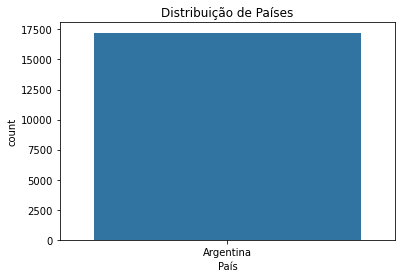

In [186]:
sns.countplot(data=df, x='country_name')
plt.title('Distribuição de Países')
plt.xlabel('País')
plt.show()

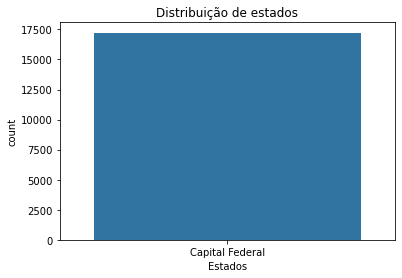

In [187]:
sns.countplot(data=df, x='state_name')
plt.title('Distribuição de estados')
plt.xlabel('Estados')
plt.show()

## Os dados das habitações estão concentrados em casas classificadas como "Apartamentos"

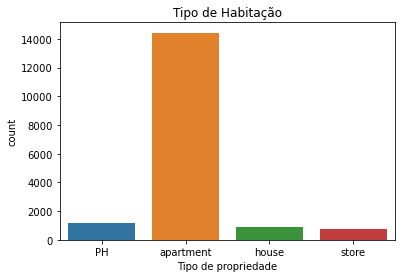

In [188]:
# grande parte dos imoveis estão concentrados em apartamentos
sns.countplot(data = df, x = 'property_type')
plt.title('Tipo de Habitação')
plt.xlabel('Tipo de propriedade')
plt.show()

In [189]:
df['place_name'].value_counts()

Palermo            1502
Belgrano           1496
Caballito          1389
Recoleta           1001
Flores              893
                   ... 
Parque Chas          15
Palermo Viejo        10
Villa Soldati         7
Villa Riachuelo       3
Catalinas             1
Name: place_name, Length: 62, dtype: int64

## Nota-se que os valores dos apartamentos contém diversos outliers.

### As observações consideradas outliers serão removidas.

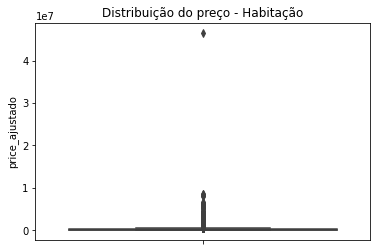

In [190]:
# distribuição do preço
sns.boxplot(data= df, y='price_ajustado')
plt.title('Distribuição do preço - Habitação')
plt.show()

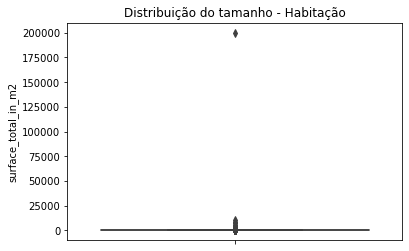

In [191]:
sns.boxplot(data = df, y='surface_total_in_m2')
plt.title('Distribuição do tamanho - Habitação')
plt.show()

## Remoção de Outliers

In [192]:
q3, q1 = np.percentile(df['price_ajustado'], [75, 25])

print(f"primeiro quartil: ", q1)
print(f"terceiro quartil: ", q3)

primeiro quartil:  101100.0
terceiro quartil:  275000.0


In [193]:

dfContador_75 = df['price_ajustado'] > 275000.0

dfData_75 = df[dfContador_75]

indice75 = df[df['price_ajustado'] > 275000.0].index

df = df.drop(indice75, inplace = False)

In [194]:
# retirar metragem = 0

zeros = df['surface_total_in_m2'] == 0
df = df[~zeros]

## Checando a distribuição das colunas que foram tratadas através do IQR

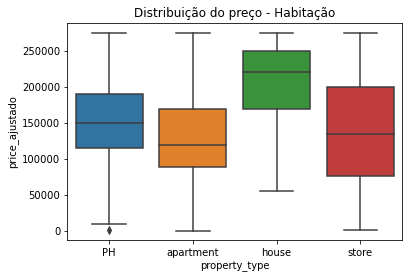

In [195]:
sns.boxplot(data = df,
            y = 'price_ajustado',
            x = 'property_type')
plt.title('Distribuição do preço - Habitação')
plt.show()

In [196]:
q3, q1 = np.percentile(df['surface_total_in_m2'], [75, 25])

print(f"primeiro quartil: ", q1)
print(f"terceiro quartil: ", q3)

primeiro quartil:  40.0
terceiro quartil:  78.0


In [197]:
dfarea_75 = df['surface_total_in_m2'] > 78.0

dfdataarea_75 = df[dfarea_75]

area75 = df[df['surface_total_in_m2'] > 78.0].index

df = df.drop(area75, inplace = False)

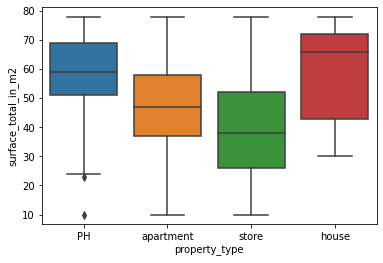

In [198]:
sns.boxplot(
    data = df,
    y = 'surface_total_in_m2',
    x = 'property_type'
)
plt.show()

## Checando a correlação das variáveis "área total da habitação em M2" e "preço convertido"

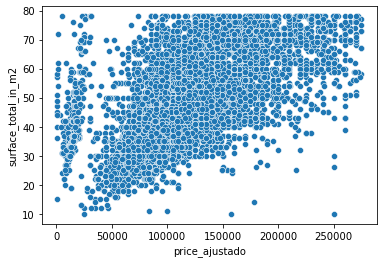

In [199]:
sns.scatterplot(
    data=df,
    y = 'surface_total_in_m2',
    x = 'price_ajustado'
)
plt.show()

In [200]:
# calculando distancia para o centro

ponto_marcozero = (-34.609447506344914, -58.38743491792922)

In [201]:
for i in df.index:
    df.loc[i, 'distancia'] = geopy.distance.geodesic(ponto_marcozero,
                                                     (df.loc[i, 'geometry'].x,
                                                      df.loc[i, 'geometry'].y)
                                                     ).kilometers

In [202]:
df['distancia'].describe()

count    9807.000000
mean        5.675802
std         7.100516
min         0.074452
25%         2.746787
50%         5.300913
75%         8.244592
max       630.542367
Name: distancia, dtype: float64

In [215]:
_i = df[df['distancia'] > 600].index

df.drop(_i, inplace=True)

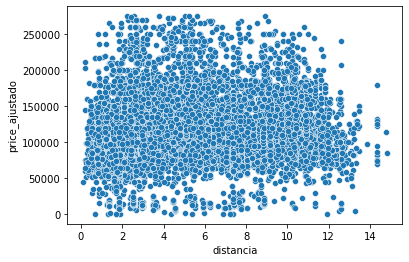

In [216]:
sns.scatterplot(
    data=df,
    y = 'price_ajustado',
    x = 'distancia'
)
plt.show()

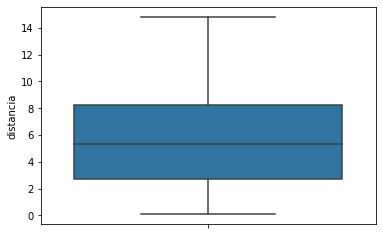

In [218]:
sns.boxplot(
    data = df,
    y = 'distancia'
    #x = 'property_type'
)
plt.show()

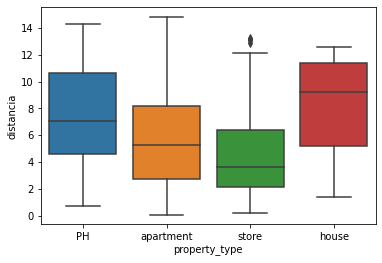

In [220]:
sns.boxplot(
    data = df,
    y = 'distancia',
    x = 'property_type'
)
plt.show()

In [211]:
top5bairros	= df['place_name'].value_counts().head(5).index

In [205]:
top5bairros = df[df['place_name'].isin(top5bairros)]

## Selecionando colunas que serão utilizadas na criação do modelo.

In [206]:
df.columns

Index(['property_type', 'place_name', 'country_name', 'state_name', 'lat',
       'lon', 'price', 'currency', 'surface_total_in_m2', 'price_ajustado',
       'currency_ajustado', 'geometry', 'distancia'],
      dtype='object')

In [207]:
df_modelo = df_final[['property_type', 'place_name', 'surface_total_in_m2', 'price_ajustado']]

NameError: name 'df_final' is not defined

In [ ]:
# importando bibliotecas para gerar regressão linear

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [ ]:
# separando os dados em treino e teste
df_treino, df_teste = train_test_split(df_modelo, test_size=0.3, random_state=13)

print(f'Número de observações em treino: {df_treino.shape[0]}')
print(f'Número de observações em teste: {df_teste.shape[0]}')


Número de observações em treino: 10033
Número de observações em teste: 4301


In [ ]:
# criando variável para avaliar o modelo
model = LinearRegression()

In [ ]:
# separando variaveis independentes das dependentes
X_train = df_treino[['surface_total_in_m2', 'property_type']]
Y_train = df_treino[['price_ajustado']]

In [ ]:
# criando dummies para as variaveis categoricas

cat_dummies = pd.get_dummies(data=X_train,
                             columns=['property_type'],
                             drop_first=False,
                             prefix=['prop'])

In [ ]:
#aplicando dummies na variável x
X_train = cat_dummies

In [ ]:
# criando o modelo
model = LinearRegression().fit(X_train, Y_train)

In [ ]:
# mensurando o R2 da equação
r2 = model.score(X_train,Y_train)
print(f'valor de R2: {r2}')

valor de R2: 0.5478408886217252


In [ ]:
# separando variaveis independentes das dependentes
x_test = df_teste[['surface_total_in_m2', 'property_type']]
y_test = df_teste[['price_ajustado']]

In [ ]:
cat_dummies_test = pd.get_dummies(data=x_test,
                   columns=['property_type'],
                   drop_first=False,
                   prefix=['prop'])

x_test = cat_dummies_test

In [ ]:
x_test.head()

,surface_total_in_m2,prop_PH,prop_apartment,prop_house,prop_store
8436,78.0,0,1,0,0
7984,59.0,1,0,0,0
12874,51.0,0,1,0,0
9885,85.0,0,1,0,0
3118,85.0,0,1,0,0


In [ ]:
# predizendo respostas

y_pred = model.predict(x_test)

y_pred = pd.DataFrame(y_pred, columns=['predict'])

In [ ]:
df_validacao = y_test.join(y_pred)

ValueError: x and y must be the same size

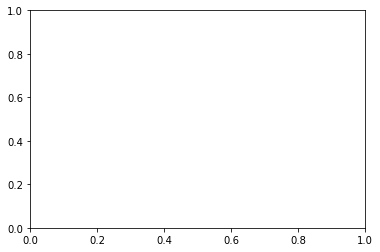

In [ ]:
plt.scatter(x_test, y_test, color = 'gray')
plt.plot(x_test, y_pred, color = 'red', linewidth = 2)
plt.show()
print(f'valor de R2: {r2}')

In [ ]:
erro_medio = metrics.mean_absolute_error(y_test, y_pred)

In [ ]:
print(erro_medio)

43784.99332982289


In [ ]:
y_pred['erro%'] = (y_pred['predict']/erro_medio).round(2)

In [ ]:
y_pred['erro%'].mean()

3.6662892350616305